In [1]:
# Uncomment to install these packages for widgets
# !pip install ipywidgets
# !pip install ipympl
# !pip install plotly

In [2]:
# Some common system imports
import os
import sys
import importlib
import time

# Numeric computing
import numpy as np
from scipy import linalg

# Sklearn functions are useful for generating train/test splits, and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# pytorch
import torch
import torch.utils.data as tdata

# Plotting
import plotly.graph_objects as go
from ipywidgets import interact
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# Dataset generating module
import my_datasets

my_datasets = importlib.reload(my_datasets)

In [3]:
# We will first define a simple linear class to train an SVM-like classifier

class LinearSVM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Generate a hyperplane operator
        self.hyperplane = torch.nn.Linear(in_features=2, out_features=1)
        
    # Pytorch requires you to just implement a forward operator, the backward
    # operator is implemented automatically (hence autodiff)
    
    def forward(self, x):
        return torch.sigmoid(self.hyperplane(x))

In [4]:
# To classify circular data, let us implement kernel

class KernelSVM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Generate a hyperplane operator
        self.hyperplane = torch.nn.Linear(in_features=4, out_features=1)
        
    # Pytorch requires you to just implement a forward operator, the backward
    # operator is implemented automatically (hence autodiff)
    
    def forward(self, x):
        x1, x2 = x[:, [0]], x[:, [1]]
        
        x = torch.hstack((x, x1**2, x2**2))
        return torch.sigmoid(self.hyperplane(x))

In [5]:
# Time to finally implement a full-fledge NN

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Simple NN with three hidden layers
        self.fc1 = torch.nn.Linear(in_features=2, out_features=6)
        self.fc2 = torch.nn.Linear(in_features=6, out_features=6)
        self.fc3 = torch.nn.Linear(in_features=6, out_features=1)
        
    # Pytorch requires you to just implement a forward operator, the backward
    # operator is implemented automatically (hence autodiff)
    
    def forward(self, x):
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        x3 = torch.sigmoid(self.fc3(x2))
        
        return x3

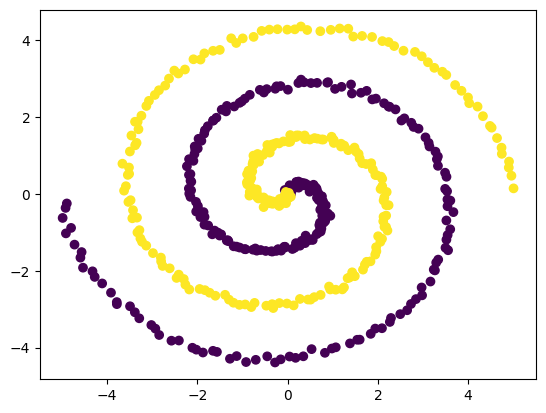

In [6]:
# Generate data
data, labels = my_datasets.get_data('spiral', 500, 0.05)

plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.show()

In [7]:
# Split data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(data,
                                                                    labels,
                                                                    train_size=0.5,
                                                                    test_size=0.5)

print(test_data.shape, test_labels.shape)

(250, 2) (250,)


In [8]:
# Convert numpy arrays to pytorch tensor
train_ten, test_ten = torch.tensor(train_data), torch.tensor(test_data)
train_y_ten, test_y_ten = torch.tensor(train_labels), torch.tensor(test_labels)

print(train_ten.size(), train_y_ten.size())
# Create datasets -- they just produce outputs, we need a separate loader
train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
test_dataset = tdata.TensorDataset(test_ten, test_y_ten)

# Now generate loaders
train_loader = tdata.DataLoader(train_dataset, batch_size=32)
test_loader = tdata.DataLoader(test_dataset, batch_size=32)

torch.Size([250, 2]) torch.Size([250])


In [9]:
# Generate placeholder plots 

fig1 = go.FigureWidget()
s1 = fig1.add_scatter(name='Train')
s2 = fig1.add_scatter(name='Test')
fig1.layout.xaxis.title = 'Epoch'
fig1.layout.yaxis.title = 'Loss (cross-entropy)'
fig1.layout.height = 500
fig1.layout.width = 500

fig1

FigureWidget({
    'data': [{'name': 'Train', 'type': 'scatter', 'uid': '5d5eaa36-88c1-4c11-a605-673cca8aa085'…

In [10]:
x = np.random.rand(100)
y = np.random.rand(100)

fig2 = go.FigureWidget()
fig2.layout.xaxis.title = 'X1'
fig2.layout.yaxis.title = 'X2'
fig2.layout.height = 500
fig2.layout.width = 500

grid_size = 100
minx, miny = -5, -5
maxx, maxy = 5, 5

density = (maxx - minx)/grid_size

gridpts = np.mgrid[minx:maxx:density , miny:maxy:density].reshape(2,-1).T

grid_ten = torch.tensor(gridpts, dtype=torch.float32 )


fake_labels = torch.zeros([grid_size**2], dtype=torch.float32 )
grid_dataset = tdata.TensorDataset(grid_ten, fake_labels)
grid_loader = tdata.DataLoader(grid_dataset, batch_size=len(grid_dataset))

fig2.add_scatter(x = gridpts[:,0], y = gridpts[:,1], name='Grid', mode='markers', hoverinfo='skip')

grid = fig2.data[0]
grid.marker.color = .7
grid.marker.size = 3
grid.marker.symbol = 1
grid.marker.opacity=0.5
grid.showlegend=False

# Add Datapoints on top
fig2.add_scatter(x=data[:, 0], y=data[:, 1], mode='markers', name="Data")
scatter = fig2.data[1]
scatter.marker.color = labels

    
fig2

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'marker': {'color': 0.7, 'opacity': 0.5, 'size…

In [11]:
def plot_loss(loss_array, test_loss_array, epoch_idx):
    #fig1.data[0].y = loss_array[:epoch_idx]/train_y_ten.numel()
    #fig1.data[1].y = test_loss_array[:epoch_idx]
    #fig1.update_yaxes(type="log")
    
    fig.data[0].y = loss_array[:epoch_idx]/train_y_ten.numel()
    fig.data[1].y = test_loss_array[:epoch_idx]
    fig.layout['yaxis'].update(type="log")
    

def plot_boundaries():
    for grid_batch, labels_batch in grid_loader:
        with torch.no_grad():
            grid_labels = model(grid_batch)
            colors = grid_labels.detach().numpy().flatten()
            #grid.marker.color = colors
            fig.data[2].marker.color = colors
    
    
    

In [12]:
fig = go.FigureWidget().set_subplots(1, 2, horizontal_spacing=0.1)#make_subplots(rows=1, cols=2)
fig.add_trace(fig1.data[0], row=1, col=1,)
fig.add_trace(fig1.data[1], row=1, col=1,)
fig.add_trace(fig2.data[0], row=1, col=2,)
fig.add_trace(fig2.data[1], row=1, col=2,)

fig

FigureWidget({
    'data': [{'name': 'Train',
              'type': 'scatter',
              'uid': 'cf70525c-…

In [19]:
# Set learning parameters here
lr = 1e-2
n_epochs = 1501

# Let us now instantiate a new SVM model
model = MLP()

# Create a cross entropy loss
criterion = torch.nn.BCELoss()

# We need an optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

# Store loss so that we can plot it live
loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)

# Time to train
for epoch_idx in range(n_epochs):
    # Iterate over the dataset
    for batch in train_loader:
        data_batch, labels_batch = batch
        
        # Predict with our model
        labels_pred = model(data_batch)
        
        # Compute loss function. Be extremely careful. It HAS to be 
        # criterion(predicted, gt), not the other way around
        loss = criterion(labels_pred.flatten(), labels_batch)
        
        # Store the loss function
        loss_array[epoch_idx] += loss.item()*data_batch.shape[0]
        
        # Now backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate testing accuracy. Disable gradients since we do not need 
        # them for testing
        with torch.no_grad():
            test_pred = model(test_ten).flatten()
            test_loss_array[epoch_idx] = criterion(test_pred, test_y_ten)
        
    # Now let us plot our loss
    if epoch_idx%100 == 0:
        plot_loss(loss_array, test_loss_array, epoch_idx)
        plot_boundaries()


In [14]:
# Time to train
for epoch_idx in range(n_epochs):
    # Iterate over the dataset
    for batch in train_loader:
        data_batch, labels_batch = batch
        
        # Predict with our model
        labels_pred = model(data_batch)
        
        # Compute loss function. Be extremely careful. It HAS to be 
        # criterion(predicted, gt), not the other way around
        loss = criterion(labels_pred.flatten(), labels_batch)
        
        # Store the loss function
        loss_array[epoch_idx] += loss.item()*data_batch.shape[0]
        
        # Now backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate testing accuracy. Disable gradients since we do not need 
        # them for testing
        with torch.no_grad():
            test_pred = model(test_ten).flatten()
            test_loss_array[epoch_idx] = criterion(test_pred, test_y_ten)
        
    # Now let us plot our loss
    if epoch_idx%100 == 0:
        plot_loss(loss_array, test_loss_array, epoch_idx)
        plot_boundaries()


In [15]:
# Evaluate on test data
with torch.no_grad():
    test_pred = model(test_ten).flatten()

# Time to print classification report
print(classification_report(test_y_ten, test_pred > 0.5))


              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       125
         1.0       0.75      0.81      0.78       125

    accuracy                           0.77       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250

